# Star Counts

This notebook contains the data analyis for the Star Counts lab exercise. Refer to your manual for detailed instructions. 

## Setup

The following two code cells import the material you will need for this lab: first the Python 3 modules and packages, and then the data files. 

Run these cells without editing them. At this stage, you are not required to understand the details of what these cells are doing. If you are interested, however, you may refer to the extensive Python documentation available online. 

Reminder: run (execute) cells with *SHIFT*-*ENTER*. This works for both code and markdown cells. 


## IMPORTANT
This program needs a Python package, _Photutils_ to do all the photometry. Open a Syzygy terminal, and install this package using the following command
 
pip install --user photutils --no-deps

### Import Python Modules and Packages

In [54]:
# common/useful python packages
import numpy as np
import os
from scipy import stats 

# image reading and analysis
import astropy.io.fits as pyfits
from astropy.stats import sigma_clipped_stats

# photometry packages - very important for this lab!
# - we will use the photutils classes DAOStarFinder and CircularAperture, 
#   and the function aperture_photometry
# - these are accessed by calling photutils.aperture_photometry(), etc
# documentation available at https://photutils.readthedocs.io/en/stable/
import photutils

# plotting packages
# - matplotlib.pyplot is the most useful/basic one
# - skimage helps with image processing
import matplotlib.pyplot as plt 
import skimage

# helper packages for accessing data 
import urllib, zipfile, tarfile
from urllib.request import urlretrieve
import warnings

### Load Data

In [55]:
# Check if data dir exists. If not, retrieve data from UVic website.
# Data is retrieved as a tarball and untarred in your home directory.

datadir = 'StarCounts'

if not(os.path.exists(datadir) and os.path.isdir(datadir)):
    url = 'http://astrowww.phys.uvic.ca/~astrolab/AstroLabs/A250/'
    tgz = datadir+'.tgz'
    urlretrieve(url+tgz, filename=tgz)
    tar = tarfile.open(tgz)
    tar.extractall()
    tar.close()

# Print out details
print('Lab data directory: '+datadir)
print('List of available files:')
file_list = os.listdir(datadir)
for file in file_list:
    print(file)    

# ignore any warnings (they are mostly due to unexpected 
# formatting in the fits files' headers)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

Lab data directory: StarCounts
List of available files:
field06.fits
field02.fits
Sample1.fits
field07.fits
field03.fits
pol3906.fit
field05.fits
field01.fits
field04.fits


## Data Analysis

This is where the action begins! 

Choose any one image from the list of files above. The code below will use 'Sample1.fits' as an example, but you should choose a different file for your analysis. 

Your lab manual's Procedure describes the steps that you will be following to analyze your data. Refer to these steps as a roadmap as you work through the analysis. 

### STEP 1: Get image information from the fits header.

Remember to replace "Sample1.fits" with one of the other images!

In [56]:
# build the path to your file
datadir = 'StarCounts'
fits_filename = 'field02.fits'
fits_path = datadir+'/'+fits_filename

# use pyfits to read the header. 
image_header = pyfits.getheader(fits_path, ext=0)

# print out the header data we're interested in
header_details = ['PINAME','DATE','OBJECT','RA','DEC','INSTRUME','FILTER','NAXIS1','NAXIS2','EXPTIME','GAIN']
for header_name in header_details:
    header_value = image_header[header_name]
    print(header_name+' = '+str(header_value))

PINAME = Balam
DATE = 2018-09-02T15:14:19
OBJECT = P10J3YG 38.2@241
RA = 23:00:52.830
DEC = +06:57:21.05
INSTRUME = Newtonian Imager
FILTER = SDSS g prime
NAXIS1 = 2292
NAXIS2 = 1028
EXPTIME = 170
GAIN = 3.2


### STEP 2: Read in the image and display it. 

Number of rows, columns in image: 1028, 2292


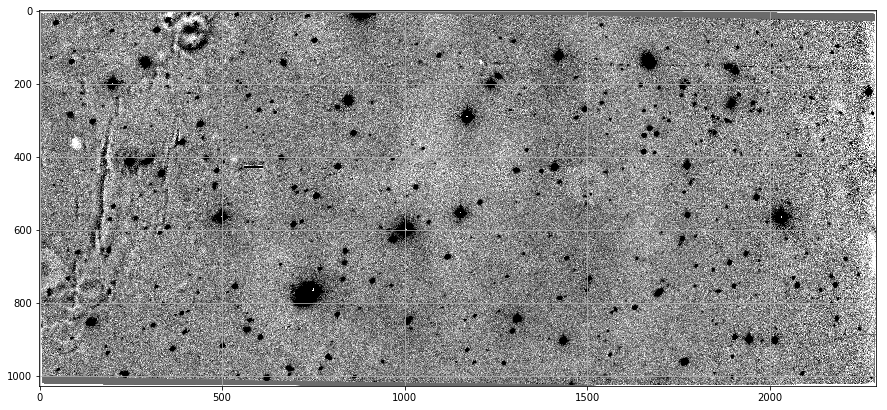

In [57]:
# read the image data
image_data = pyfits.getdata(fits_path, ext=0)

# find the size of the image data array
[rows,cols] = image_data.shape
print('Number of rows, columns in image: %d, %d' %(rows,cols))

# make a copy of the data that is rescaled for better contrast
p2, p98 = np.percentile(image_data, (2, 98))
img_rescale = skimage.exposure.rescale_intensity(image_data, in_range=(p2, p98))

# display the image using an inverted greyscale colormap
plt.figure(figsize=(15,30))
plt.imshow(img_rescale, cmap='gray_r')
plt.grid(True)  # plots gridlines to help read axes

### STEP 3: Choose a sub-region.

**These images have not been sky subtracted**. Therefore, the flux in any pixel includes contribution from the sky background. This sky background value has to be subtracted before we can do photometry.

We need to choose a region of the image to measure this background, and do some other statistical analysis. This region should be relatively free of stars, but also large enough to get robust statistics. 

Choose a region to analyze. Stay well away from the image edges, and avoid saturated stars and other artifacts. Recommended region size: <=250 rows, <=400 columns.

**IMPORTANT NOTE: Python is row-dominant.** When you choose coordinates, the first set of coordinates defines your rows (ie corresponds to the vertical/y axis), and the second set of coordinates defines your columns (ie corresponds to the horizontal/x axis.)

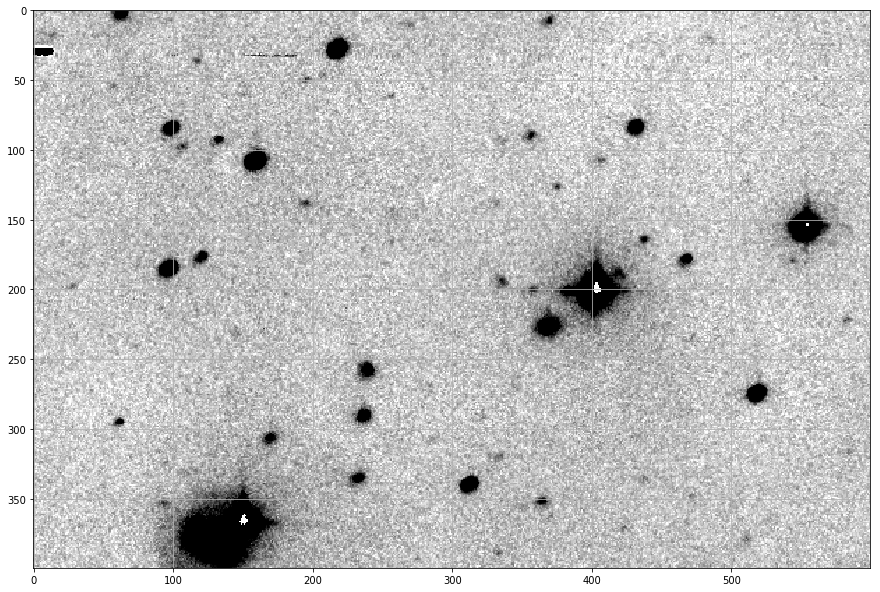

In [58]:
# Choose the row and column range of your chosen sub-region. 
# Use the format "image_region = image_data[row1:row2,col1:col2]"
image_region = image_data[400:800,600:1200]  # ENTER VALUE

# Make a copy of your subregion that is rescaled for better contrast.
p2, p98 = np.percentile(image_region, (2, 98))
region_rescale = skimage.exposure.rescale_intensity(image_region, in_range=(p2, p98))

# display the image using an inverted greyscale colormap
plt.figure(figsize=(15,30))
plt.imshow(region_rescale, cmap='gray_r')
plt.grid(True)  # plots gridlines to help read axes

### STEP 4: Measure the sky background and some statistics. 

We will assume that the sky background is uniform over the whole image. 

Even with careful choice of the sub-region, you will notice that it includes several (faint) stars, which skew the statistics.  To account for this, we will estimate the sky background in two steps: 

  1. Estimate the mean, median, and standard deviation of the sub-region.
  2. Use the *sigma-clipping* algorithm to reject outliers, and re-estimate the statistics.
  
Sigma-clipping is a useful technique that allows us to measure robust statistics, even in the presence of outliers. We will be using a pre-made algorithm from the *astropy* library. If you would like to understand the syntax, its documentation is available [online](https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clipped_stats.html).

In the first step, the standard deviation (noise) will be very high due to the presence of outliers (stars). In the second stage, this noise will be reduced, and we will get a better estimate of the sky background. Remember to round your values to a useful number of digits. 

In [59]:
# measure basic statistics in the sub-region
mean = np.mean(image_region)
median = np.median(image_region)
stddev = np.std(image_region)
print('Statistics from raw image:' \
      +' mean = %.2f, median = %.2f, stddev = %.2f' %(mean,median,stddev))

# use the sigma-clipping algorithm to reject outliers
sc_mean, sc_median, sc_stddev = sigma_clipped_stats(image_region, sigma=5.0, maxiters=5)

print('Statistics after sigma-clipping: ' \
      +' mean = %.2f, median = %.2f, stddev = %.2f' %(sc_mean,sc_median,sc_stddev))


Statistics from raw image: mean = 1008.80, median = 995.75, stddev = 375.47
Statistics after sigma-clipping:  mean = 995.70, median = 995.51, stddev = 9.03


### STEP 5: Run DAOFIND on the sub-region to locate bright stars.

Before we can measure the brightness of the stars in the image, we need to find their locations and determine the best aperture size to use for measuring their flux. The aperture size depends on the point spread function (PSF) in the observation, which is characterized by its full width at half max (FWHM).

In this step, we will use an approximate aperture size and locate only the very bright stars. Once we have measurements of a good star, we will use it to refine our aperture estimate (in Step 6). 

In order to find only bright stars ("sources"), we will set the detection threshold to be $20\sigma$ above the sky background. The noise level, $\sigma$, is equal to the standard deviation *sc_stddev,* and the sky background is given by *sc_median.* In other words, only stars more than $20\times$ brighter than the average sky noise will be identified as sources.

  id   xcentroid ycentroid sharpness roundness1 ...  sky    peak    flux   mag  
------ --------- --------- --------- ---------- ... ----- -------- ------ ------
 1.000    63.278     1.690     0.507     -0.168 ... 0.000  243.939  1.744 -0.604
 2.000   219.326    25.795     0.491     -0.367 ... 0.000 4418.770 33.639 -3.817
 3.000   432.448    81.841     0.529      0.031 ... 0.000  554.490  3.674 -1.413
 4.000   100.044    82.790     0.506     -0.284 ... 0.000 1019.958  7.792 -2.229
 5.000   132.825    92.066     0.589     -0.326 ... 0.000  156.736  1.126 -0.129
 6.000   160.558   106.146     0.524     -0.258 ... 0.000 5898.378 44.208 -4.114
 7.000   121.362   175.561     0.535     -0.346 ... 0.000  260.763  1.916 -0.706
 8.000   468.744   177.448     0.534     -0.289 ... 0.000  325.655  2.401 -0.951
 9.000    98.355   183.260     0.497     -0.250 ... 0.000 2441.089 18.538 -3.170
10.000   369.911   225.461     0.489     -0.483 ... 0.000  555.276  3.273 -1.287
11.000   519.990   272.733  

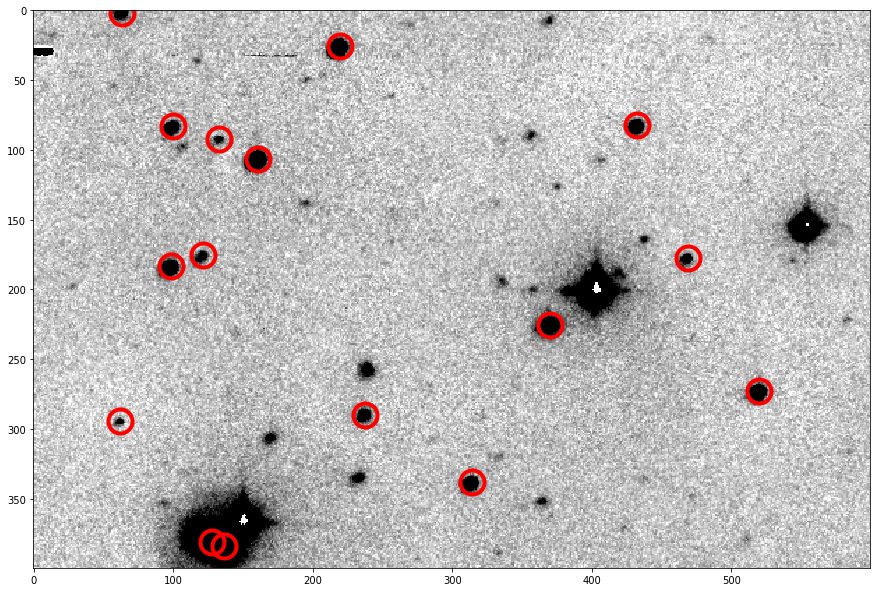

In [60]:
# set approximate approximate fwhm to use for aperture, 
# then use daofind to locate bright stars in the subregion

approx_fwhm = 5 # pixels
threshold = 20.*sc_stddev
daofind = photutils.DAOStarFinder(fwhm=approx_fwhm, threshold=threshold) 
sources = daofind(image_region - sc_median) # find sources in the sky-subtracted image

# print out source data as a table
for colname in sources.colnames:
    sources[colname].info.format = '%.3f' 
print(sources)

# plot the subregion, and circle the bright stars found by daofind
plt.figure(figsize=(15,30))
plt.imshow(region_rescale, cmap='gray_r')
plt.plot(sources['xcentroid'], sources['ycentroid'], \
         ls='',marker='o',mec='r',mfc='none',mew=4,ms=24)

### STEP 6: Find the optimal aperture using a curve of growth

In the DAOFind output table above, the locations of the bright stars are given by the columns *xcentroid* and *ycentroid*. Choose one of those stars which is unsaturated (without diffraction spikes).

Define a series of apertures of increasing size, and estimate the flux contained within each one. (We will do both of these steps with functions from the *photutils* package.) The optimal aperture is the one that contains all the flux without including too many sky pixels.

**NOTE: Test the following cell with several stars, and check whether you get consistent values of the optimal aperture**.


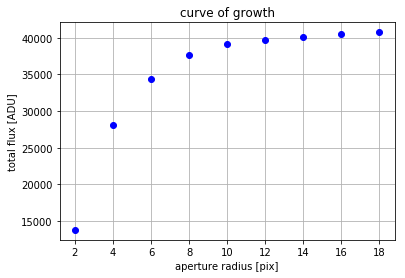

In [61]:
# choose a bright, unsaturated star (specify by its ID number)
star_id =  14  # ENTER VALUE
star_num = star_id - 1 # because python counts from 0 but the table counts from 1
position = [(sources['xcentroid'][star_num], sources['ycentroid'][star_num])]

# create a list of apertures of increasing radius
radius_list = range(2,20,2) # min=2pix, max=20pix, step=2
flux_list = [] # an empty list to hold the measured flux in each aperture

for aperture_radius in radius_list:
    apertures = photutils.CircularAperture(position, r=aperture_radius)
    phot_table = photutils.aperture_photometry(image_region-sc_median, apertures)
    flux_value = phot_table['aperture_sum'][0]
    flux_list.append(flux_value)

# convert the flux list into an array, to make math and indexing easier
flux_list = np.array(flux_list)

# plot aperture radius vs measured flux to determine optimal aperture
plt.figure()
plt.plot(radius_list,flux_list,'bo')
plt.title('curve of growth')
plt.xlabel('aperture radius [pix]')
plt.ylabel('total flux [ADU]')
plt.grid(True)  # plots gridlines to help read axes

The curve of growth flattens with increasing radius, then begins to rise again. This secondary increase is due to contributions from sky noise and nearby stars, which should not be included in estimates of our star's flux.

The radius at which the curve of growth flattens, before increasing due to other sources, is the optimal aperture radius. Enter this value in the Step 7 code cell. 

### STEP 7: Use aperture photometry to measure all the sources in the image. 

Having determined the sky background and optimal aperture for photometry, we can do photometry on the full image. The steps are exactly the same as when we ran DAOFIND with an approximate aperture, but the input variables will be different.

Previously, we only wanted to detect the very bright stars, so we used a detection threshold of $20\sigma$. This means that only stars more than $20\times$ brighter than the average sky noise $\sigma$ (sc_stddev) were identified as sources. This time, we want to detect *all* of the stars, so we will set a lower threshold.  

In [62]:
# set the aperture size and detection threshold 
optimal_aperture = 10 # ENTER VALUE (determined in step 6)
threshold = 3. * sc_stddev # try changing to a different multiple of sc_stddev

# detect sources in the full image
daofind = photutils.DAOStarFinder(fwhm=optimal_aperture, threshold=threshold) 
sources = daofind(image_data - sc_median) # notice that we are subtracting the sky background

# measure the sources using aperture photometry
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = photutils.CircularAperture(positions, r=optimal_aperture)
phot_table = photutils.aperture_photometry(image_data - sc_median, apertures)

# print the results in a nicely formatted table
for colname in phot_table.colnames:
    phot_table[colname].info.format = '%.3f'
print(phot_table)


   id    xcenter  ycenter  aperture_sum
           pix      pix                
-------- -------- -------- ------------
   1.000    9.794   10.833  -111088.338
   2.000 2283.179   13.427   -88729.205
   3.000  735.589   14.866     7401.655
   4.000 1024.536   18.842     -103.172
   5.000  190.548   17.180     -131.736
   6.000  902.610   16.433     7922.129
   7.000  208.531   20.409      -34.149
   8.000  514.555   21.163     -884.197
   9.000  684.148   19.583     -264.533
  10.000 1056.000   21.068    -1303.409
     ...      ...      ...          ...
2570.000 1034.680 1010.156      844.986
2571.000 1365.293 1009.436      630.305
2572.000 1797.219 1011.003     -200.056
2573.000 2068.071 1010.521     -818.792
2574.000 1779.770 1010.174      110.339
2575.000 1808.116 1011.904     -231.250
2576.000  952.031 1013.525      737.689
2577.000 1251.344 1013.586      594.042
2578.000 1492.850 1017.367    -1013.167
2579.000   12.521 1016.260  -100126.609
Length = 2579 rows


### STEP 8: Convert the fluxes into magnitudes

Our photometry table contaims the positions and fluxes (recorded as *aperture_sum*) of all the stars identified by DAOFIND. The units of aperture_sum are ADU (analogue-to-digital units). Some stars have negative aperture_sum values. These are bad data points, caused by bad pixels, bad CCD columns, etc; we will remove them.

We need apparent magnitudes, not fluxes, to build our luminosity function. To convert from flux to magnitudes, we need to know the flux zero point (ZP), which is obtained by observing a *flux standard star*. The apparent magnitude $m$ is then given by: 

$m = -2.5\log_{10}(\rm{aperture\_sum}) + \rm{ZP}$

**For these observations, the zero point is 25.**

In [63]:
# flux zero point
ZP = 25.

# extract the aperture sum column from the phot table, convert to array
# remove any negative fluxes
aperture_sum = np.array(phot_table['aperture_sum'])
good_aperture_sum = aperture_sum[aperture_sum > 0.]

# calculate magnitudes
log10_flux = np.log10(good_aperture_sum)
apparent_magnitude = -2.5 * log10_flux + ZP

# print data to make sure the negative values were successfully removed
# (formatting yields a nicely readable table)
print('%10s %10s' % ('Flux','Magnitude'))
for a,m in zip(good_aperture_sum, apparent_magnitude):
    print('%10.1f %10.3f' % (a,m))


      Flux  Magnitude
    7401.7     15.327
    7922.1     15.253
     245.4     19.025
    1026.2     17.472
     689.0     17.905
     490.9     18.272
    1710.0     16.918
    1758.3     16.887
      93.5     20.073
     211.9     19.184
     615.1     18.028
     709.8     17.872
     552.1     18.145
    4499.4     15.867
     503.9     18.244
     525.2     18.199
   45248.0     13.361
     988.3     17.513
     479.1     18.299
     213.5     19.177
     338.2     18.677
    2678.5     16.430
     406.2     18.478
      47.2     20.816
     381.4     18.546
     377.1     18.559
    3445.5     16.157
     396.2     18.505
    1508.8     17.053
     548.5     18.152
     156.9     19.511
     329.1     18.707
  100686.0     12.493
     857.6     17.667
     194.7     19.276
     939.7     17.568
    5449.5     15.659
    4171.0     15.949
    3313.6     16.199
      49.7     20.759
    8743.2     15.146
    2705.2     16.420
    1787.9     16.869
    4444.5     15.880
     523.2

### STEP 9: Construct a Luminosity Function

We can now construct a luminosity function as described in the manual's introduction. To do so, we need to plot the apparent magnitudes as a histogram. 

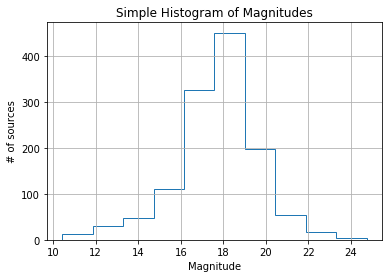

In [64]:
# Plot a simple histogram first to see the distribution of magnitudes
plt.figure
plt.hist(apparent_magnitude,histtype='step')
plt.title('Simple Histogram of Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('# of sources')
plt.grid(True)

As expected, this histogram shows that the number of stars increases as we go to fainter magnitudes (toward increasing values). 

However, the trend reverses and the number of stars decreases above apparent magnitude = 18 (in these observations). This is due to a drop in the data's *completeness*. We will therefore only use the part of the histogram below magnitude = 18 to build our luminosity function.


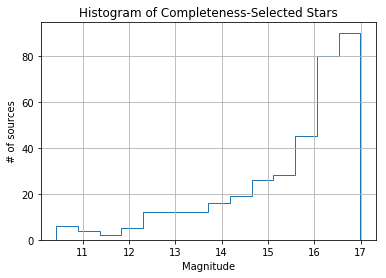

In [65]:
# choose only the stars with magnitude < chosen completeness limit
completeness_limit = 17.
select_apparent_magnitude = apparent_magnitude[apparent_magnitude < completeness_limit]

# determine number of bins for histogram (want bin width = 0.5)
max_mag = max(select_apparent_magnitude)
min_mag = min(select_apparent_magnitude)
bin_size = 0.5
nbins = int((max_mag-min_mag)/bin_size) + 1

# plot histogram
plt.figure()
plt.hist(select_apparent_magnitude,bins=nbins,histtype='step')
plt.title('Histogram of Completeness-Selected Stars')
plt.xlabel('Magnitude')
plt.ylabel('# of sources')
plt.grid(True)


### STEP 10: Determine the slope of the luminosity function

Recall our theoretical prediction (equation 2.6 in the manual): 

$\log N = K + 0.6m$

This is a linear fit, like $y = mx+b$, to the *log* of the number of measured stars as a function of their apparent magnitude. We want to compare our results to this prediction.

To do so, we will choose a magnitude range within which to measure the slope, then determine a fit using a linear regression function from the SciPy Stats package. This function returns the slope and also the error in the fitted value (along with other output not needed for our analysis). 

Slope of luminosity function = 0.23137721952277018
Fit error on slope = 0.023431462660712544


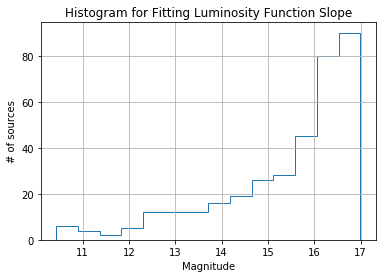

In [66]:
# choose magnitude limits based on the plot above
mag_low =  5  # ENTER VALUE
mag_high = 17  # ENTER VALUE
select_apparent_magnitude = apparent_magnitude[(apparent_magnitude > mag_low) * (apparent_magnitude < mag_high)]

# choose bins for a new histogram using just the selected magnitude range
max_mag = max(select_apparent_magnitude)
min_mag = min(select_apparent_magnitude)
bin_size = 0.5
nbins = int((max_mag-min_mag)/bin_size) + 1

# plot this new histogram 
# (we don't need the plot, but calling plt.hist also returns the N- and m-data)
plt.figure()
Nstars, mag_bins, extra_stuff = plt.hist(select_apparent_magnitude,bins=nbins,histtype='step')
plt.title('Histogram for Fitting Luminosity Function Slope')
plt.xlabel('Magnitude')
plt.ylabel('# of sources')

# take log of hist_vals; trim off the last mag bin so both arrays are the same length
log_Nstars = np.log10(Nstars)
mag_bins = mag_bins[0:-1]

# fit a straight line to the plot of m vs log_N
slope, intercept, r_value, p_value, std_err = stats.linregress(mag_bins,log_Nstars)
print('Slope of luminosity function = '+str(slope))
print('Fit error on slope = '+str(std_err))
plt.grid(True)


#### Plot the histogram again, with its fitted slope, to make sure the fit is reasonable.

Luminosity Function
   Magnitude   Obs Nstars   Fit Nstars
        10.4            6          3.0
        10.9            4          3.8
        11.4            2          4.9
        11.8            5          6.3
        12.3           12          8.0
        12.8           12         10.3
        13.2           12         13.3
        13.7           16         17.0
        14.2           19         21.9
        14.7           26         28.1
        15.1           28         36.0
        15.6           45         46.3
        16.1           80         59.4
        16.5           90         76.3


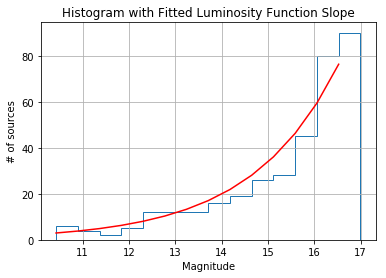

In [67]:
# generate a line from the fit results, convert to linear scale (fit was to log_N)
fit_log_hist = slope * mag_bins + intercept
fit_hist = np.power(10,fit_log_hist)

# plot the histogram and fit together
plt.figure()
plt.hist(select_apparent_magnitude,bins=nbins,histtype='step')
plt.plot(mag_bins,fit_hist,'r-')
plt.title('Histogram with Fitted Luminosity Function Slope')
plt.xlabel('Magnitude')
plt.ylabel('# of sources')
plt.grid(True)
    
print('Luminosity Function')
print('%12s %12s %12s' % ('Magnitude','Obs Nstars','Fit Nstars'))
for mag,obs,fit in zip(mag_bins,Nstars,fit_hist):
     print('%12.1f %12d %12.1f' %(mag,obs,fit))
        

In [68]:
# release all the plot handles and clean up
plt.close('all')

### STEP 11: Generalize to the whole sky.

The luminosity function calculated above gives the number of stars as a function of magnitude *within our image.* It is more useful to know the typical number of these stars in the whole sky, which can be expressed as the predicted number of stars of a given magnitude *per square degree.*

To calculate this, we need to know the size of our image. All of the images used in this lab were taken at the DAO's 1.8m Plaskett telescope, using the Newtonian Imaging Camera. The detector's scale is 0.62"/pixel. Recall that the header information from Step 1 included the values *NAXIS1* and *NAXIS2*; these are the image dimensions in pixels. 

  1. Calculate the camera's field of view in square degrees. 
  2. Use your luminosity function to calculate the number of stars per square degree at the following apparent magnitudes: 15, 13, 4. 
  

In [76]:
# calcuate the FoV and stars per degree at m=15,13,4
#Field of View calculation:
from sympy import *
import sympy as sp
import numpy as np
scale=0.62
area=2292*1028
area_sqdeg=(scale**2)*area/3600/3600 #Area in arcseconds
print('The field of view of the camera is',area_sqdeg,'in square degrees')
#Use the data to get k
num_star=10
mag=13
k=-slope*mag+(math.log10(num_star))
print('The constant k is',k)

#Put the value of k in the formula
#the number of magnitude stars per square degree
magnitude=4
num=(10**(k+slope*magnitude))/area_sqdeg
print('The number of 4th magnitude stars is',num,'per square degree')
for magnitude in range (13,16):
    mag_var=k+slope*magnitude
    num=(10**(mag_var))/area_seqdg
    print('The number of the stars for',magnitude,'the magnitude I predicted is equal to',num,'per square degree')

The field of view of the camera is 0.06988534370370371 in square degrees
The constant k is -2.0079038537960123
The number of 4th magnitude stars is 1.1836380528674975 per square degree


NameError: name 'area_seqdg' is not defined

#### Refer to your lab manual for questions and discussion pointers.